<a href="https://colab.research.google.com/github/MercyMoparthy/CNN-Project/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Set Seed for Reproducibility

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

## Data Preprocessing

In [4]:
def load_and_preprocess_data():
    # Load CIFAR10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encode the labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Split Training data into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


## Plot for Training Data

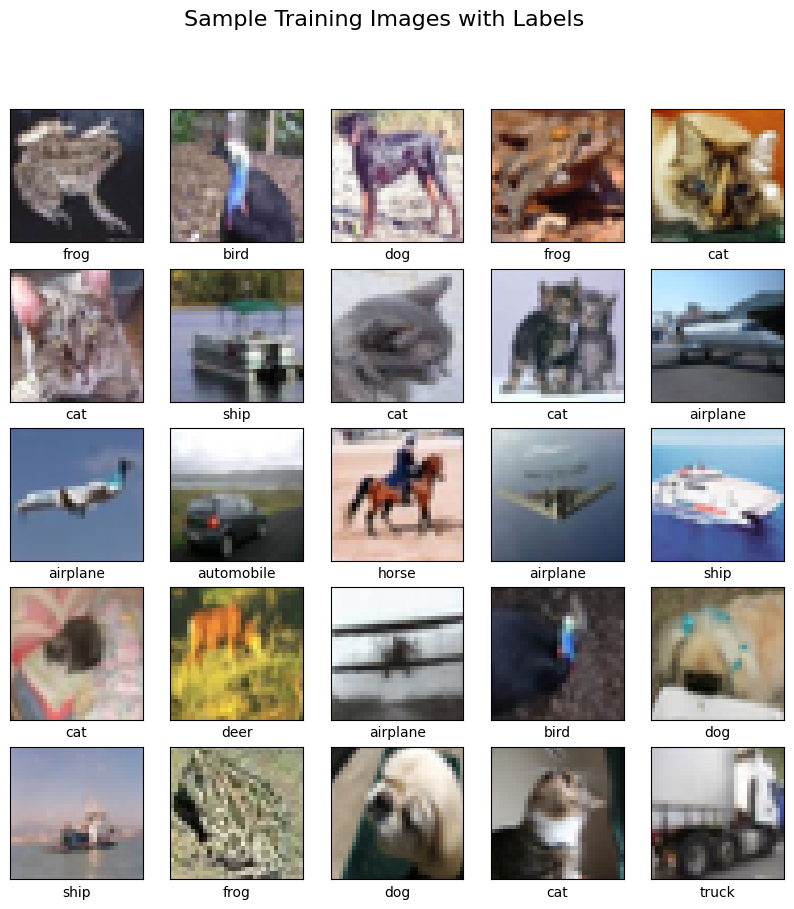

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.suptitle('Sample Training Images with Labels', fontsize=16)
plt.show()

## Build the ResNet Model

In [6]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """A residual block with two 3x3 convolutions."""
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                kernel_regularizer=regularizers.l2(1e-4))(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    """Build ResNet model for CIFAR10."""
    inputs = tf.keras.Input(shape=input_shape)
     # Initial conv layer
    x = layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # First stack of residual blocks
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    # Second stack of residual blocks
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64)

    # Third stack of residual blocks
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    # Global average pooling and final dense layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=regularizers.l2(1e-4))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_resnet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      1,056 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      1,056 │ activation_2[0][

 Total params: 723,786 (2.76 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 2,752 (10.75 KB)

## Model Compilation and Trainig

In [7]:
 def lr_schedule(epoch):
    """Learning rate schedule."""
    lr = 1e-3
    if epoch > 75:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.5
    return lr

# Callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Compile the Model

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(x_train)

## Plot the model

In [9]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 124ms/step - accuracy: 0.4009 - loss: 1.7498 - val_accuracy: 0.3140 - val_loss: 2.3166 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6283 - loss: 1.1901 - val_accuracy: 0.4896 - val_loss: 1.9034 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.6926 - loss: 1.0036 - val_accuracy: 0.5465 - val_loss: 1.8443 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7373 - loss: 0.8906 - val_accuracy: 0.6447 - val_loss: 1.2592 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.7663 - loss: 0.8126 - val_accuracy: 0.6190 - val_loss: 1.3193 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.7830 - loss: 0.7644 - val_accuracy: 0.6741 - val_loss: 1.2842 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8043 - loss:

## Plot the Training Model

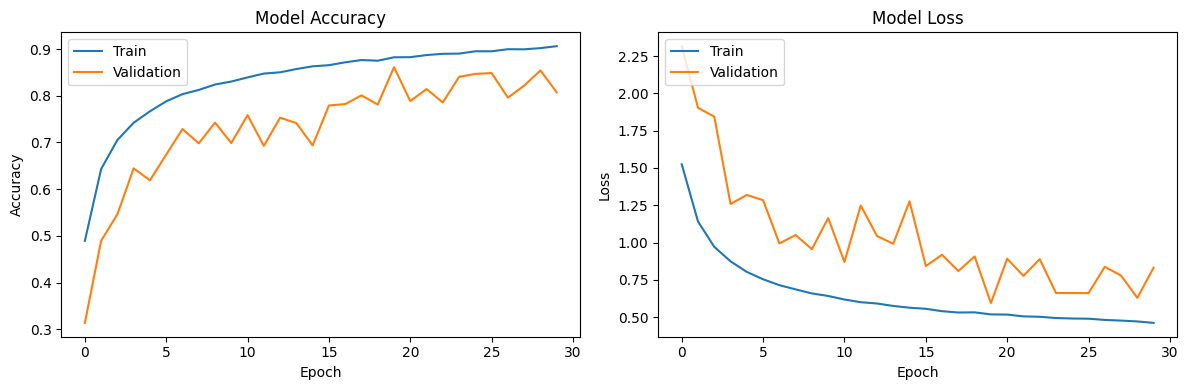

In [10]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Evaluate the Model

Test accuracy: 0.8545
Test loss: 0.6108
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


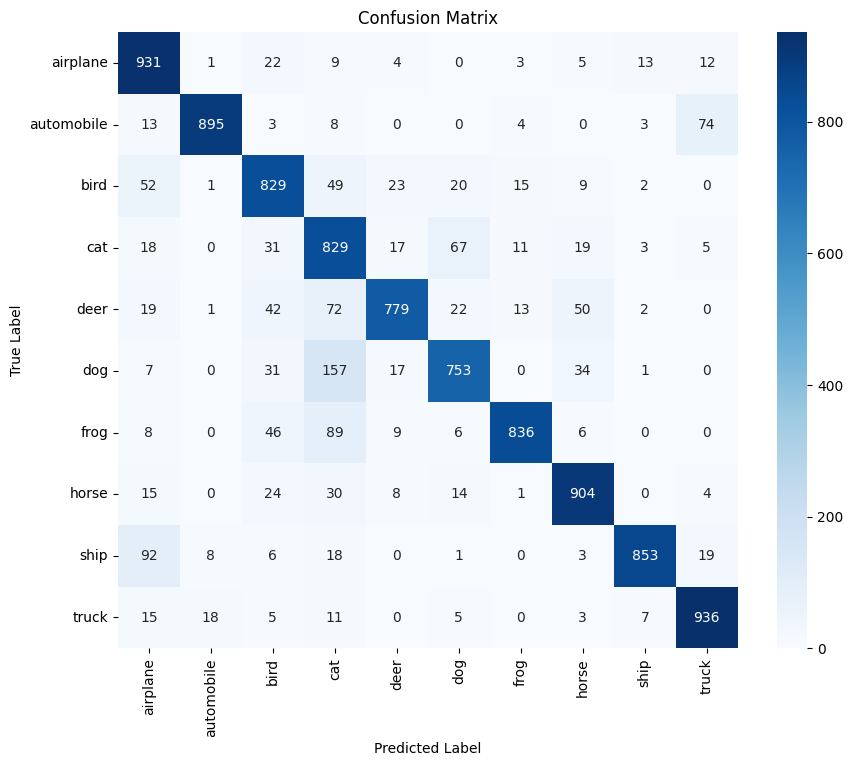

              precision    recall  f1-score   support

    airplane       0.80      0.93      0.86      1000
  automobile       0.97      0.90      0.93      1000
        bird       0.80      0.83      0.81      1000
         cat       0.65      0.83      0.73      1000
        deer       0.91      0.78      0.84      1000
         dog       0.85      0.75      0.80      1000
        frog       0.95      0.84      0.89      1000
       horse       0.88      0.90      0.89      1000
        ship       0.96      0.85      0.91      1000
       truck       0.89      0.94      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.86     10000
weighted avg       0.86      0.85      0.86     10000



In [11]:
def evaluate_model(model, x_test, y_test):
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}')

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    return test_acc, test_loss

test_acc, test_loss = evaluate_model(model, x_test, y_test)

## Sample Visualization with Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


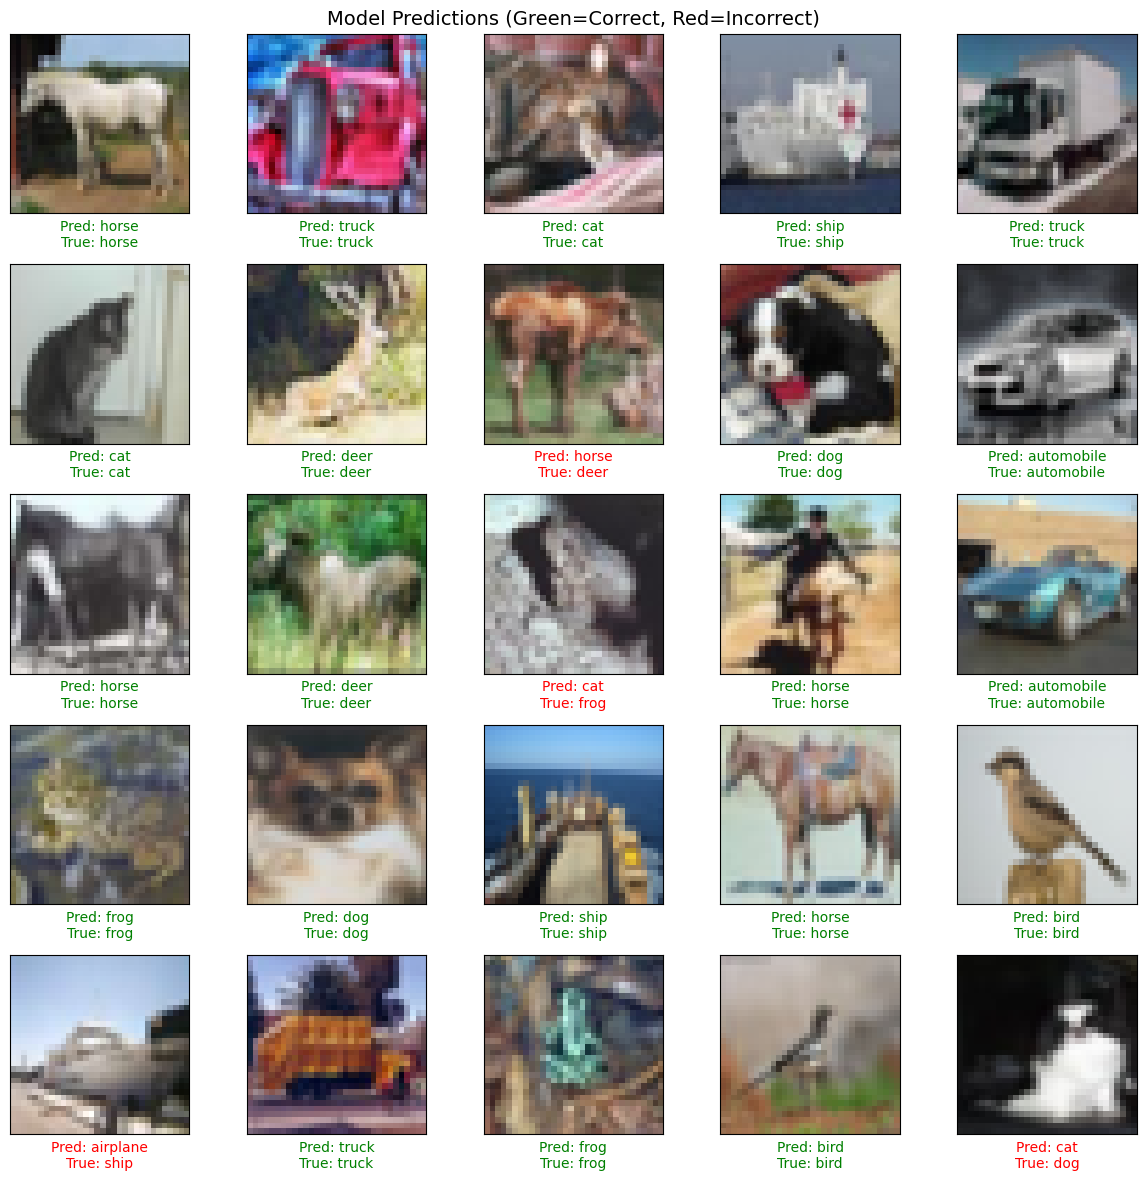

In [12]:
def visualize_predictions(model, x_test, y_test, num_samples=25):
    # Select random samples
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    sample_images = x_test[indices]
    sample_labels = y_test[indices]

    # Make predictions
    predictions = model.predict(sample_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(sample_labels, axis=1)

    # Plot the images with predictions
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(sample_images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Green for correct predictions, red for incorrect
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        plt.xlabel(f'Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}',
                  color=color)
    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_test, y_test)